In [ ]:
!pip install catboost
!pip install shap

     |████████████████████████████████| 67.3MB 56kB/s 
     |████████████████████████████████| 358kB 3.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491624 sha256=24d17a7812901a26c17f81c2485136bcd9256e6a62fe8085961f0b31980ca2b2
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
import warnings

import random

import numpy as np
import pandas as pd
import scipy.stats as sps

import catboost
import catboost.datasets
import shap
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", mpl.MatplotlibDeprecationWarning)
warnings.simplefilter("ignore", UserWarning)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ content/housing_price/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ content/housing_price/test.csv')

In [ ]:
train_id = train['Id']
test_id = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [ ]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train.isna().mean()

MSSubClass       0.000000
MSZoning         0.000000
LotFrontage      0.177397
LotArea          0.000000
Street           0.000000
                   ...   
MoSold           0.000000
YrSold           0.000000
SaleType         0.000000
SaleCondition    0.000000
SalePrice        0.000000
Length: 80, dtype: float64

Очистим от пропущенных данных.

In [ ]:
for item in train.columns:
  if train.isna().mean()[item] > 0.2:
    train.drop(columns=item, inplace=True)
for item in test.columns:
  if test.isna().mean()[item] > 0.2:
    test.drop(columns=item, inplace=True)

In [ ]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [ ]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    test[col] = test[col].fillna('None')

In [ ]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    test[col] = test[col].fillna(0)

In [ ]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    test[col] = test[col].fillna(0)

In [ ]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    test[col] = test[col].fillna('None')

In [ ]:
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

test["MasVnrType"] = test["MasVnrType"].fillna("None")
test["MasVnrArea"] = test["MasVnrArea"].fillna(0)

In [ ]:
train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])
test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])

In [ ]:
train = train.drop(['Utilities'], axis=1)
test = test.drop(['Utilities'], axis=1)

In [ ]:
train["Functional"] = train["Functional"].fillna("Typ")
test["Functional"] = test["Functional"].fillna("Typ")

In [ ]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])

In [ ]:
train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])

In [ ]:
train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])

test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])

In [ ]:
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])

Посмотрим на самую очевидную зависимость: цены от площади.

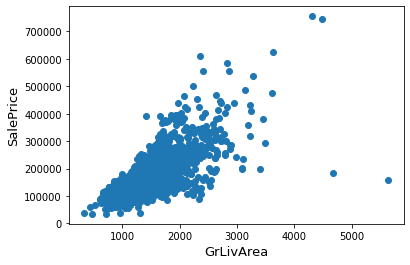

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Видим, что есть выбросы - удалим их.

Рассмотри распределение целевой переменной.

In [ ]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [ ]:
y = train['SalePrice']

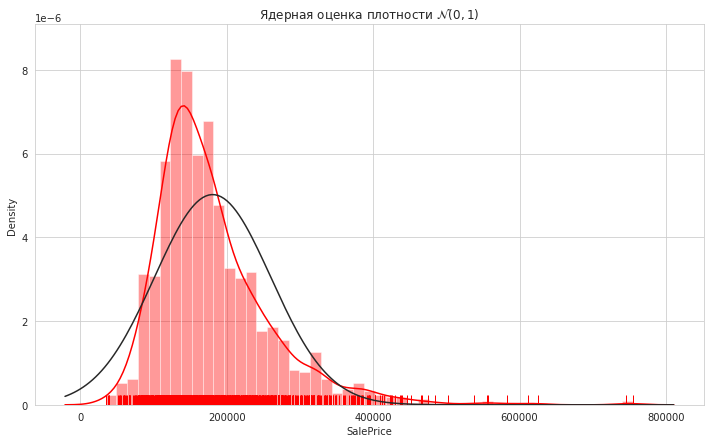

In [ ]:
with sns.plotting_context(font_scale=1.5), sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 7))
    plt.title(r"Ядерная оценка плотности $\mathcal{N}(0, 1)$")
    sns.distplot(y, rug=True, fit=sps.norm, color='red');

In [ ]:
 y = np.log(y)

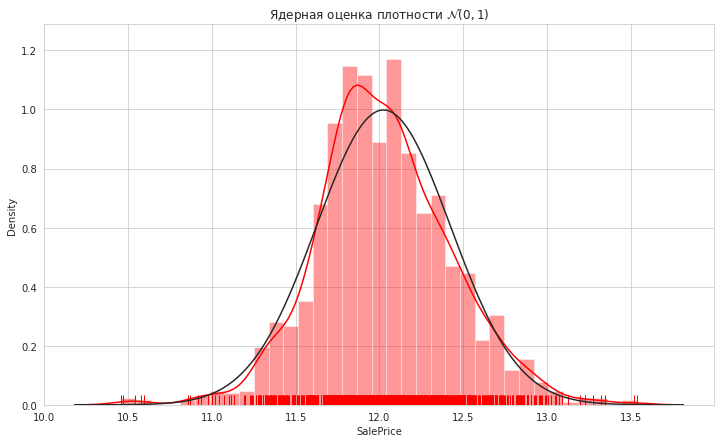

In [ ]:
with sns.plotting_context(font_scale=1.5), sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 7))
    plt.title(r"Ядерная оценка плотности $\mathcal{N}(0, 1)$")
    sns.distplot(y, rug=True, fit=sps.norm, color='red');

Расмотрим распределение целевых переменных.

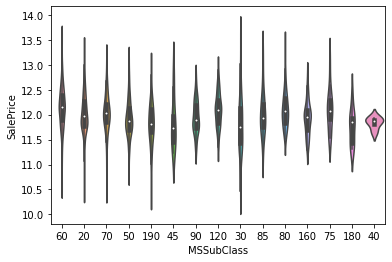

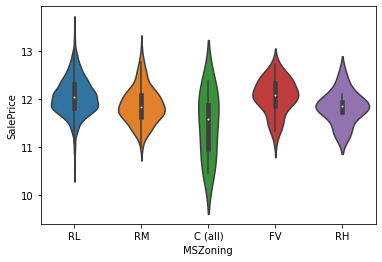

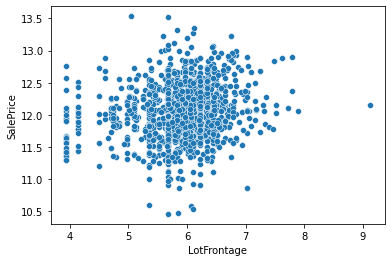

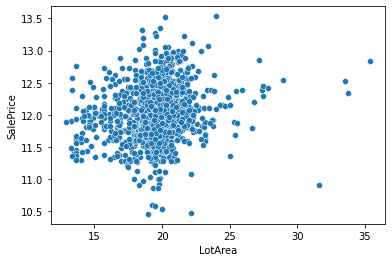

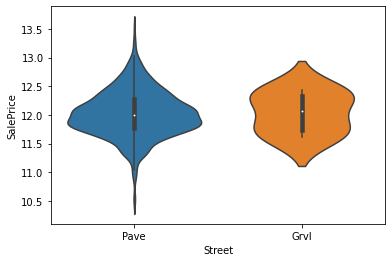

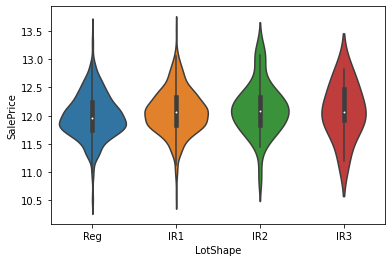

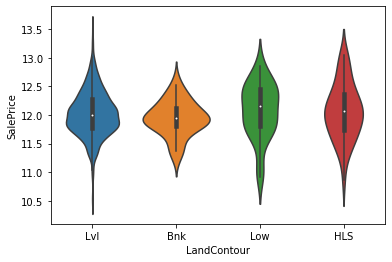

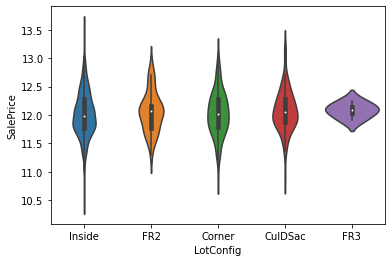

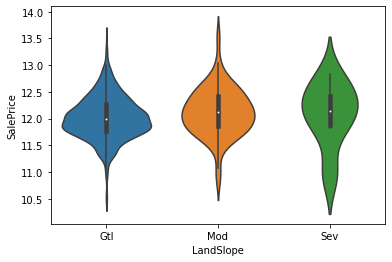

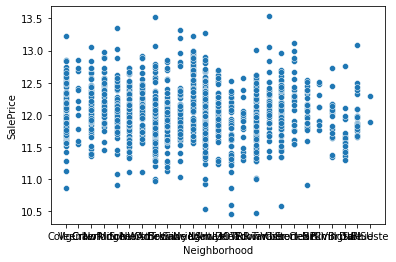

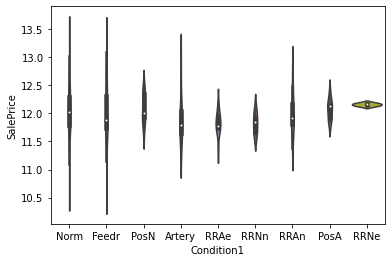

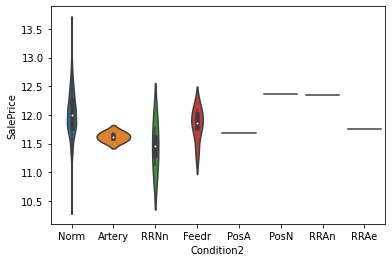

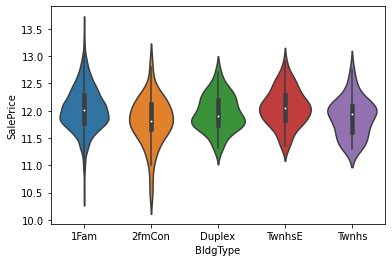

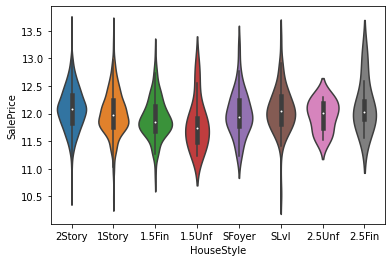

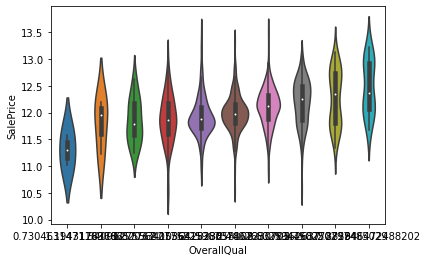

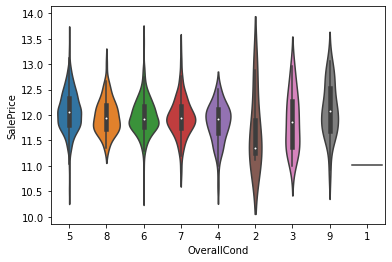

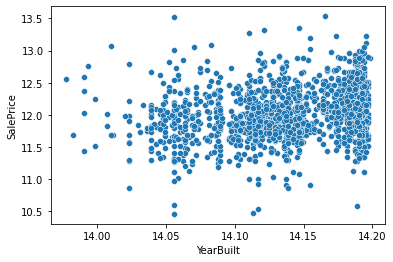

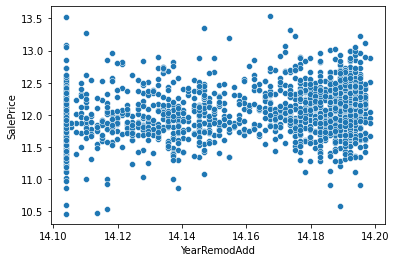

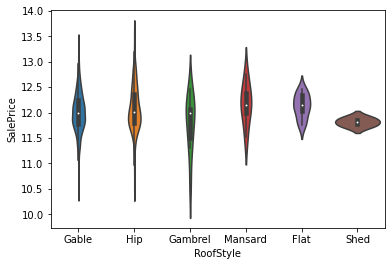

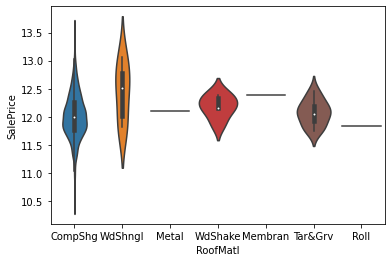

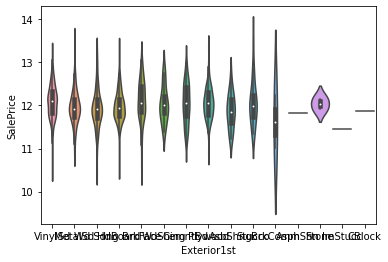

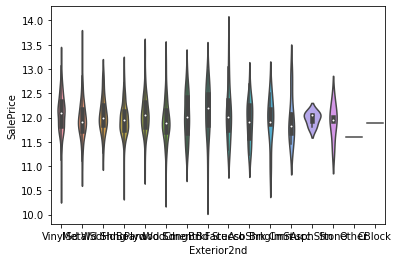

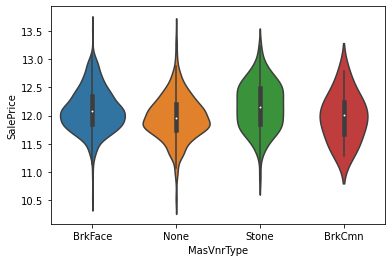

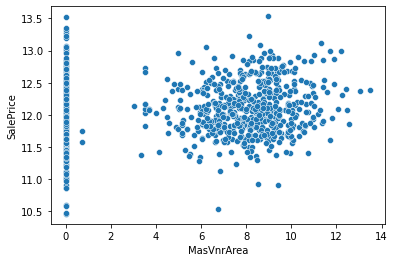

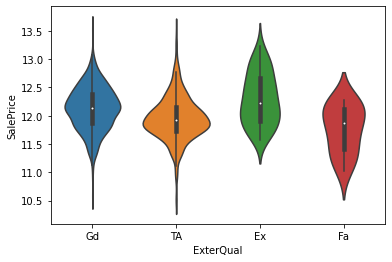

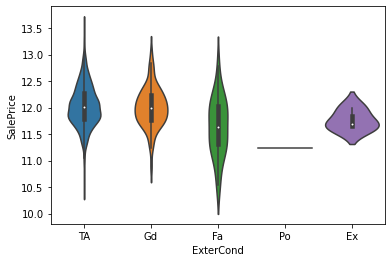

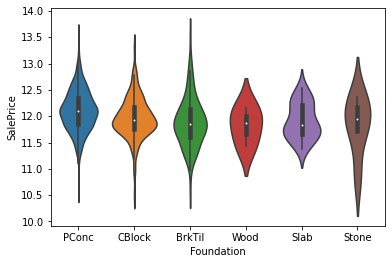

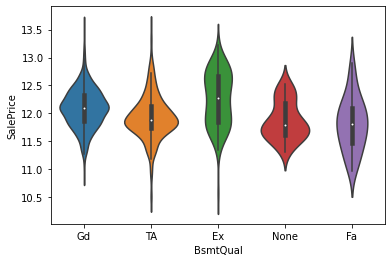

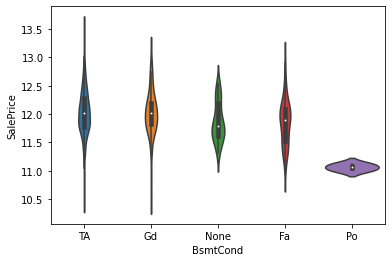

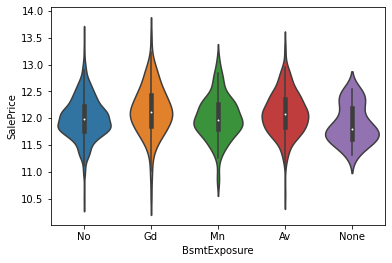

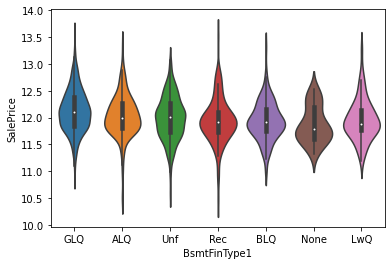

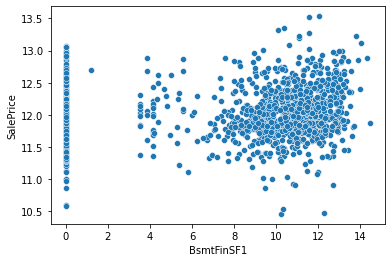

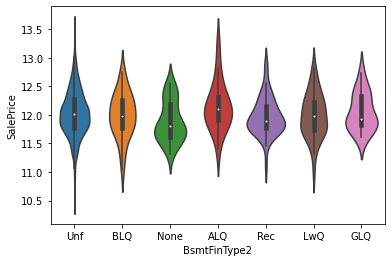

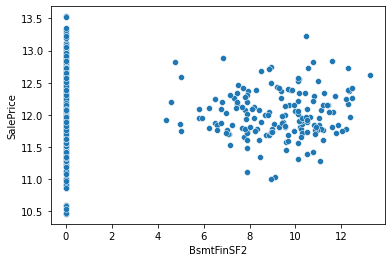

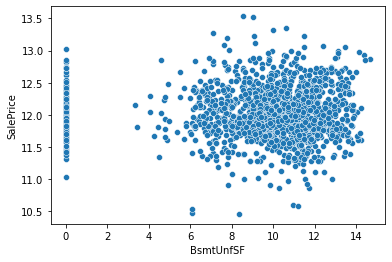

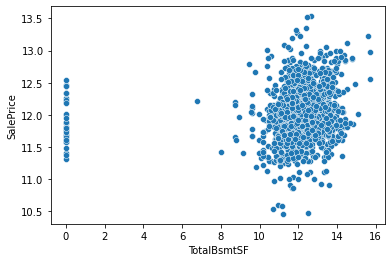

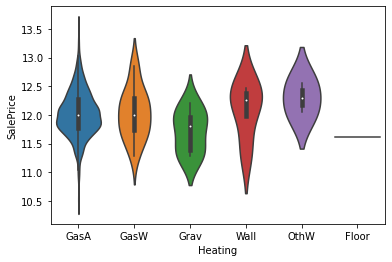

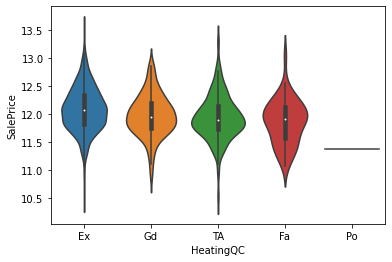

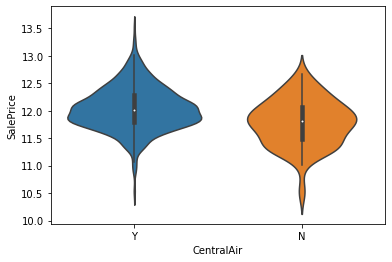

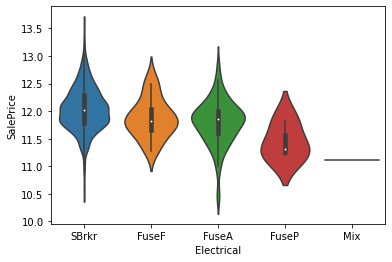

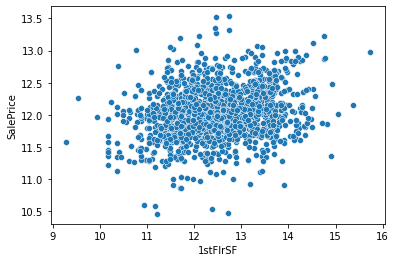

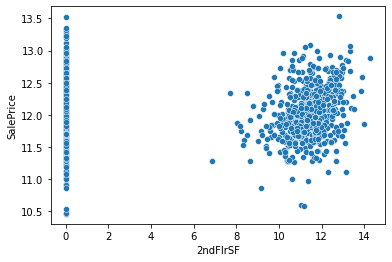

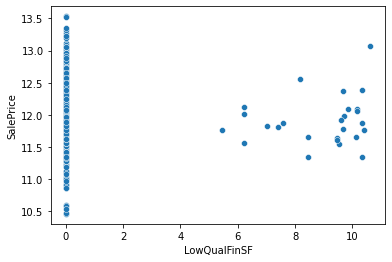

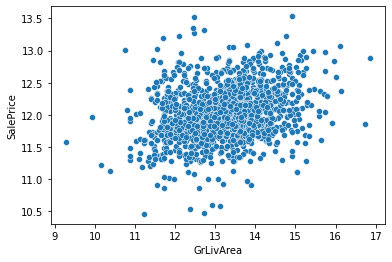

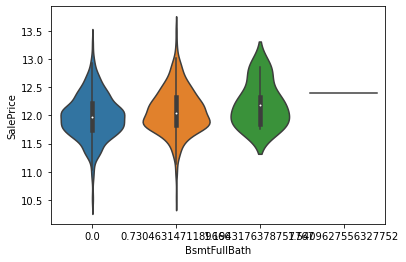

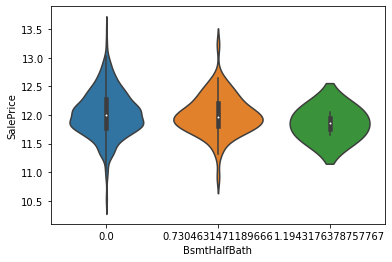

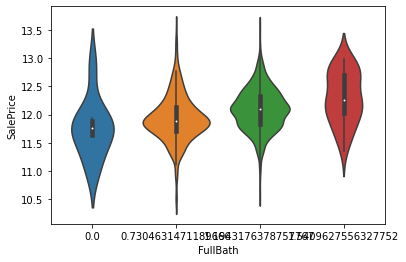

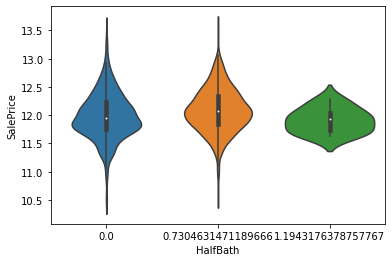

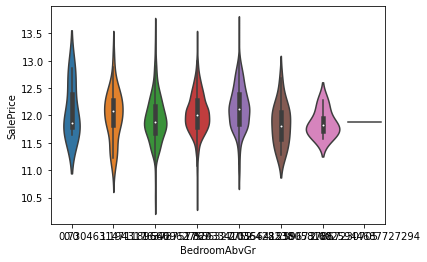

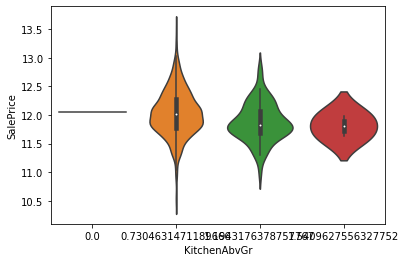

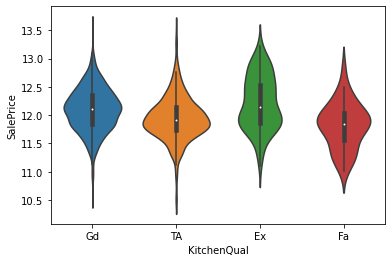

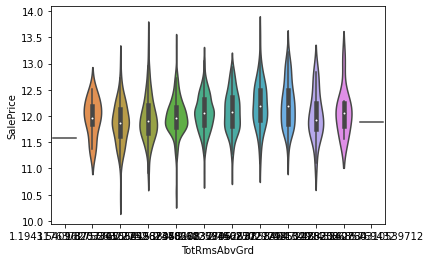

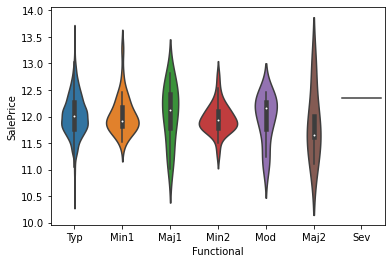

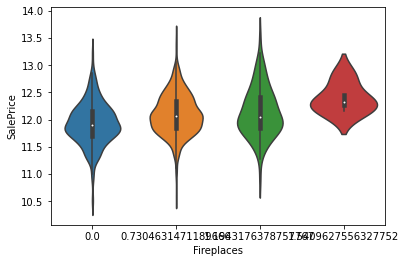

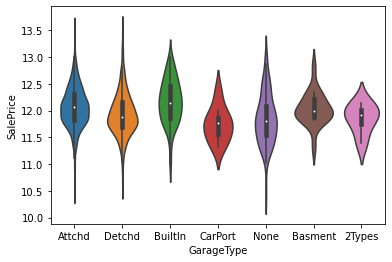

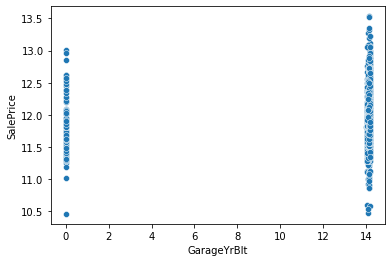

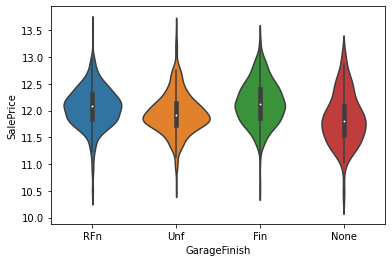

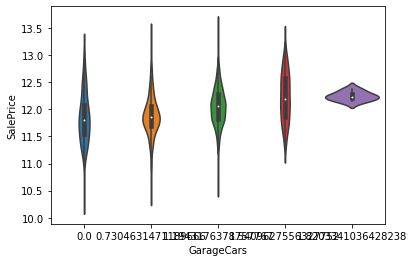

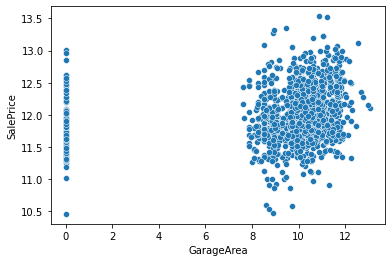

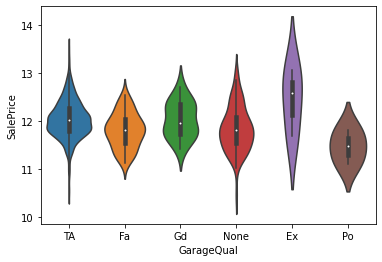

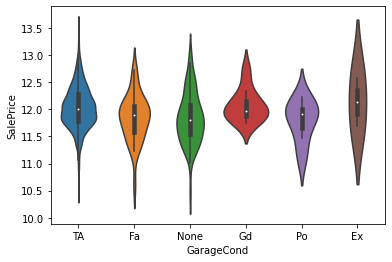

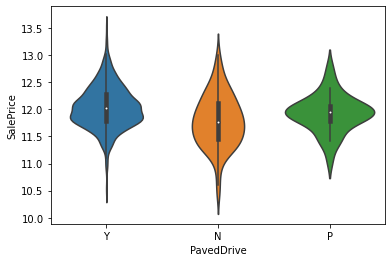

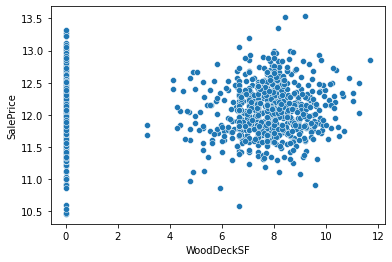

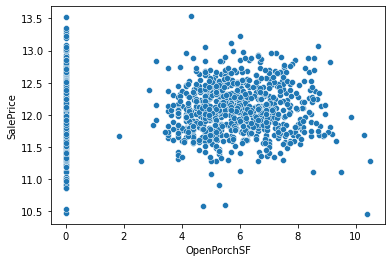

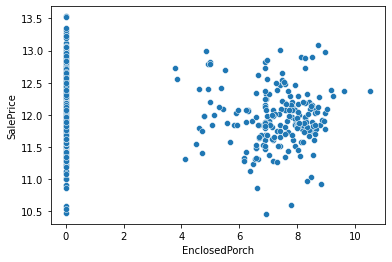

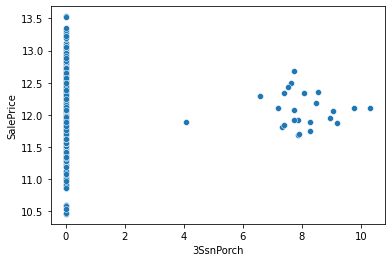

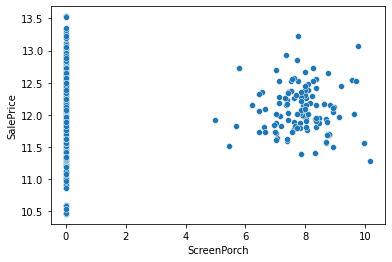

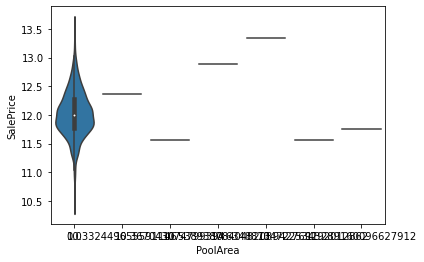

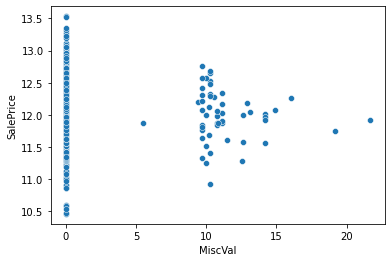

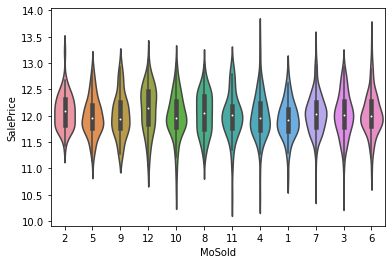

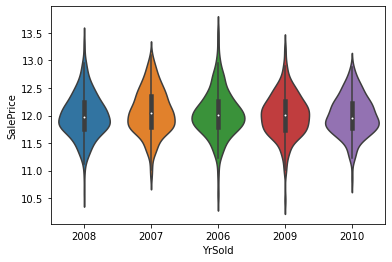

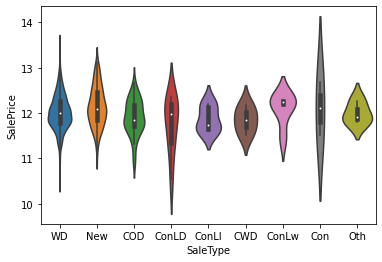

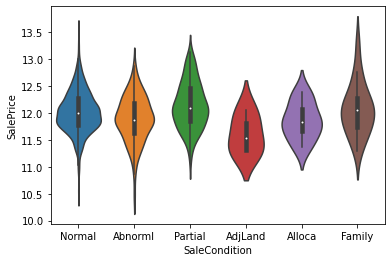

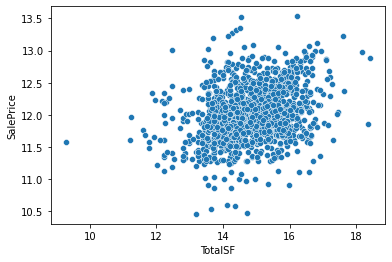

In [ ]:
for item in train.columns:
  if len(train[item].unique()) < 20:
        sns.violinplot(x=train[item],y=y)
        plt.show()
  else:
        sns.scatterplot(x=train[item],y=y)
        plt.show()

Подготовим данные

In [ ]:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [ ]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: sps.skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})

In [ ]:
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [ ]:
cat_features = ['BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'MSZoning','LandContour', 'Exterior1st', 'Electrical',
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 'Neighborhood', 'Exterior2nd', 'GarageType',
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope', 'BldgType', 'MasVnrType', 'SaleType',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 'RoofStyle', 'Foundation', 'SaleCondition',
        'YrSold', 'MoSold', 'LotConfig', 'Condition1', 'Condition2', 'HouseStyle', 'RoofMatl', 'Heating']

In [ ]:
train = all_data[:len(train)]
test = all_data[len(train):]

In [ ]:
random.seed(2021)
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    train,
    y,
    test_size=0.2,
)

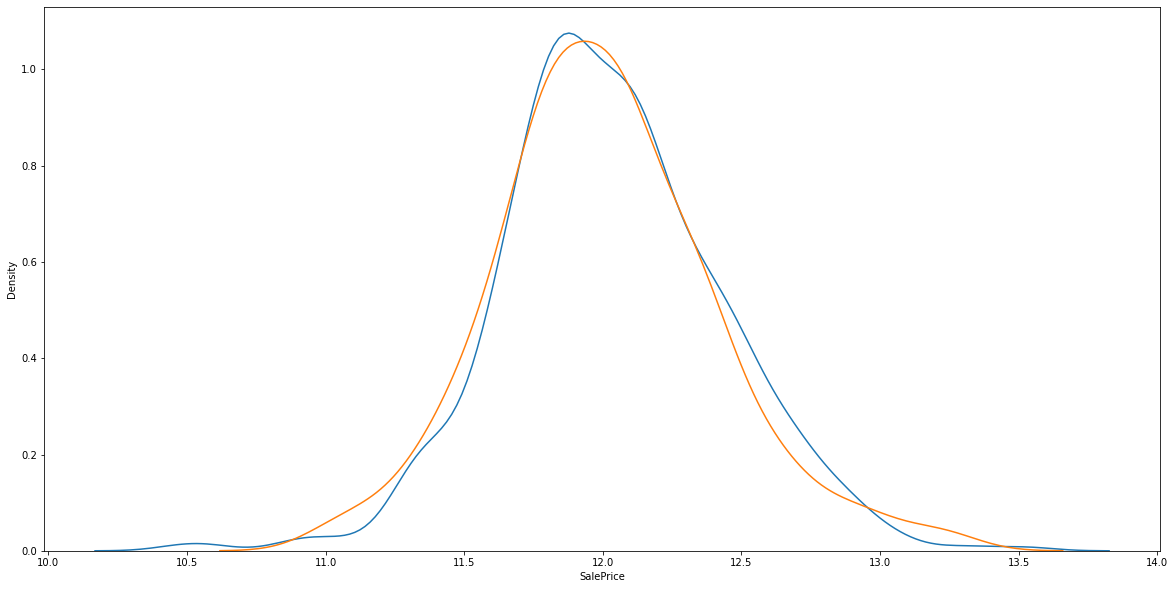

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
with sns.axes_style("whitegrid"):
    sns.kdeplot(
        data= train_y,
        palette='Set2', 
        ax=ax
    )
    sns.kdeplot(
        data= val_y,
        palette='Set2', 
        ax=ax
    )

In [ ]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF
0,60,RL,5.831328,19.212182,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,2.440268,5,14.187527,14.187527,Gable,CompShg,VinylSd,VinylSd,BrkFace,8.059126,Gd,TA,PConc,Gd,TA,No,GLQ,11.170327,Unf,0.0,7.483296,11.692623,GasA,Ex,Y,SBrkr,11.692623,11.686189,0.0,13.698888,0.730463,0.000000,1.194318,0.730463,1.540963,0.730463,Gd,2.602594,Typ,0.000000,Attchd,14.187527,RFn,1.194318,10.506271,TA,TA,Y,0.000000,5.714669,0.000000,0.0,0.0,0.0,0.0,2,2008,WD,Normal,14.976591
1,20,RL,6.221214,19.712205,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,2.259674,8,14.145138,14.145138,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,12.062832,Unf,0.0,8.897844,12.792276,GasA,Ex,Y,SBrkr,12.792276,0.000000,0.0,12.792276,0.000000,0.730463,1.194318,0.000000,1.540963,0.730463,TA,2.259674,Typ,0.730463,Attchd,14.145138,RFn,1.194318,10.062098,TA,TA,Y,9.010206,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,WD,Normal,14.923100
2,60,RL,5.914940,20.347241,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,2.440268,5,14.184404,14.185966,Gable,CompShg,VinylSd,VinylSd,BrkFace,7.646538,Gd,TA,PConc,Gd,TA,Mn,GLQ,10.200343,Unf,0.0,9.917060,11.892039,GasA,Ex,Y,SBrkr,11.892039,11.724598,0.0,13.832085,0.730463,0.000000,1.194318,0.730463,1.540963,0.730463,Gd,2.259674,Typ,0.730463,Attchd,14.184404,RFn,1.194318,10.775536,TA,TA,Y,0.000000,5.053371,0.000000,0.0,0.0,0.0,0.0,9,2008,WD,Normal,15.149678
3,70,RL,5.684507,19.691553,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,2.440268,5,14.047529,14.135652,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,8.274266,Unf,0.0,10.468500,11.354094,GasA,Gd,Y,SBrkr,12.013683,11.354094,0.0,13.711364,0.730463,0.000000,0.730463,0.000000,1.540963,0.730463,Gd,2.440268,Typ,0.730463,Detchd,14.179714,Unf,1.540963,10.918253,TA,TA,Y,0.000000,4.745132,8.797736,0.0,0.0,0.0,0.0,2,2006,WD,Abnorml,14.857121
4,60,RL,6.314735,21.325160,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,2.602594,5,14.182841,14.182841,Gable,CompShg,VinylSd,VinylSd,BrkFace,9.391827,Gd,TA,PConc,Gd,TA,Av,GLQ,10.971129,Unf,0.0,10.221051,12.510588,GasA,Ex,Y,SBrkr,12.510588,12.271365,0.0,14.480029,0.730463,0.000000,1.194318,0.730463,1.820334,0.730463,Gd,2.750250,Typ,0.730463,Attchd,14.182841,RFn,1.540963,11.627708,TA,TA,Y,8.013884,6.314735,0.000000,0.0,0.0,0.0,0.0,12,2008,WD,Normal,15.852312


In [ ]:
train_pool = catboost.Pool(
    train_X,
    label=train_y,
    cat_features=cat_features
)
val_pool = catboost.Pool(
    val_X,
    label=val_y,
    cat_features=cat_features
)
test_pool = catboost.Pool(
    test,
    cat_features=cat_features
)

In [ ]:
!rm -rf 'catboost_reg_housing_price/snapshot.bkp'

In [ ]:
catboost_train_dir = 'catboost_reg_housing_price'
reg = catboost.CatBoostRegressor(
    eval_metric='RMSE',
    od_pval=0.05,
    od_wait=20,
    random_seed=2021,
    train_dir=catboost_train_dir,
    task_type='CPU',
    max_ctr_complexity=3
)
reg.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.047434
0:	learn: 0.3884545	test: 0.3869396	best: 0.3869396 (0)	total: 128ms	remaining: 2m 7s
1:	learn: 0.3762846	test: 0.3759589	best: 0.3759589 (1)	total: 183ms	remaining: 1m 31s
2:	learn: 0.3656722	test: 0.3660398	best: 0.3660398 (2)	total: 254ms	remaining: 1m 24s
3:	learn: 0.3549713	test: 0.3551361	best: 0.3551361 (3)	total: 279ms	remaining: 1m 9s
4:	learn: 0.3443613	test: 0.3457560	best: 0.3457560 (4)	total: 309ms	remaining: 1m 1s
5:	learn: 0.3336148	test: 0.3362713	best: 0.3362713 (5)	total: 333ms	remaining: 55.1s
6:	learn: 0.3239104	test: 0.3276207	best: 0.3276207 (6)	total: 359ms	remaining: 50.9s
7:	learn: 0.3145894	test: 0.3189205	best: 0.3189205 (7)	total: 386ms	remaining: 47.9s
8:	learn: 0.3061059	test: 0.3113401	best: 0.3113401 (8)	total: 420ms	remaining: 46.3s
9:	learn: 0.2972910	test: 0.3033308	best: 0.3033308 (9)	total: 446ms	remaining: 44.1s
10:	learn: 0.2891549	test: 0.2953915	best: 0.2953915 (10)	total: 484ms	remaining: 43.6s
11:	learn: 0.2812684

In [ ]:
reg.fit(val_pool, init_model = reg)

Learning rate set to 0.03135
0:	learn: 0.1253906	total: 3.61ms	remaining: 3.6s
1:	learn: 0.1252198	total: 42.9ms	remaining: 21.4s
2:	learn: 0.1247967	total: 65.3ms	remaining: 21.7s
3:	learn: 0.1243984	total: 87.9ms	remaining: 21.9s
4:	learn: 0.1240254	total: 115ms	remaining: 23s
5:	learn: 0.1239623	total: 122ms	remaining: 20.1s
6:	learn: 0.1236756	total: 145ms	remaining: 20.6s
7:	learn: 0.1232936	total: 166ms	remaining: 20.5s
8:	learn: 0.1226866	total: 187ms	remaining: 20.6s
9:	learn: 0.1225356	total: 196ms	remaining: 19.4s
10:	learn: 0.1222826	total: 221ms	remaining: 19.9s
11:	learn: 0.1219148	total: 244ms	remaining: 20.1s
12:	learn: 0.1215567	total: 267ms	remaining: 20.3s
13:	learn: 0.1211101	total: 290ms	remaining: 20.4s
14:	learn: 0.1206230	total: 316ms	remaining: 20.7s
15:	learn: 0.1203550	total: 344ms	remaining: 21.1s
16:	learn: 0.1201185	total: 366ms	remaining: 21.2s
17:	learn: 0.1200585	total: 391ms	remaining: 21.4s
18:	learn: 0.1197749	total: 416ms	remaining: 21.5s
19:	learn: 

In [ ]:
pred = reg.predict(test_pool)

In [ ]:
pred = np.exp(pred)

In [ ]:
result = pd.DataFrame()
result['Id'] = test_id
result['SalePrice'] = pred

In [ ]:
result.to_csv('/content/drive/MyDrive/ content/housing_price/submit1.csv', encoding='utf-8', index=False)

Победа:) 3188 место из 11150! Score 0.12974